<a href="https://colab.research.google.com/github/miras1109/A-Comparative-Study-of-Decision-Tree-Random-Forest-KNN-DBSCAN-and-SVM-XGBoost-for-Football-Analytics/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import essential libraries for data manipulation, clustering, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


Shape: (2854, 267)

First 5 rows:
    Rk             Player   Nation    Pos        Squad                Comp  \
0   1         Max Aarons  eng ENG     DF  Bournemouth  eng Premier League   
1   2         Max Aarons  eng ENG  DF,MF     Valencia          es La Liga   
2   3     Rodrigo Abajas   es ESP     DF     Valencia          es La Liga   
3   4     James Abankwah   ie IRL  DF,MF      Udinese          it Serie A   
4   5  Keyliane Abdallah   fr FRA     FW    Marseille          fr Ligue 1   

    Age    Born  MP  Starts  ...  Att (GK)  Thr  Launch%  AvgLen  Opp  Stp  \
0  24.0  2000.0   3       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
1  24.0  2000.0   4       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
2  21.0  2003.0   1       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
3  20.0  2004.0   6       0  ...       NaN  NaN      NaN     NaN  NaN  NaN   
4  18.0  2006.0   1       0  ...       NaN  NaN      NaN     NaN  NaN  NaN   

   Stp%  #OPA  #OPA/90  AvgDist  

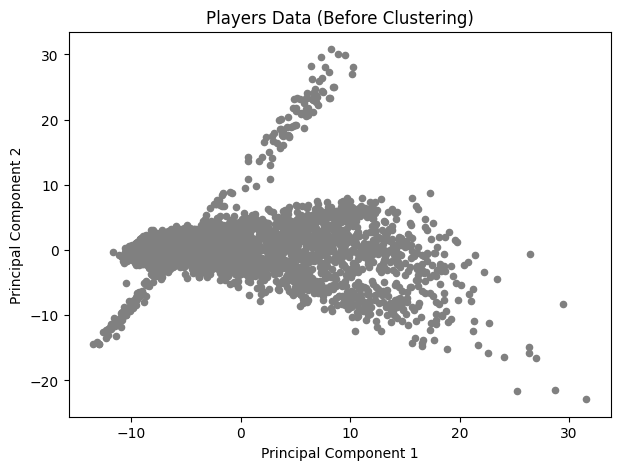

In [ ]:
# Load the players dataset (must be in your Colab working directory)
df = pd.read_csv("players_data-2024_2025.csv")

# Display shape and first few records
print("Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())

# Check for missing values in each column
print("\nMissing values:\n", df.isnull().sum())

# Identify numeric columns (only they can be clustered)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:\n", num_cols)

# Select numeric features and replace missing values with column means
X = df[num_cols].fillna(df[num_cols].mean())

# Standardize all features so each has mean = 0 and std = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce data to 2 dimensions for easy visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)

# Plot the PCA projection before clustering
plt.figure(figsize=(7,5))
plt.scatter(X_vis[:,0], X_vis[:,1], c='gray', s=20)
plt.title("Players Data (Before Clustering)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


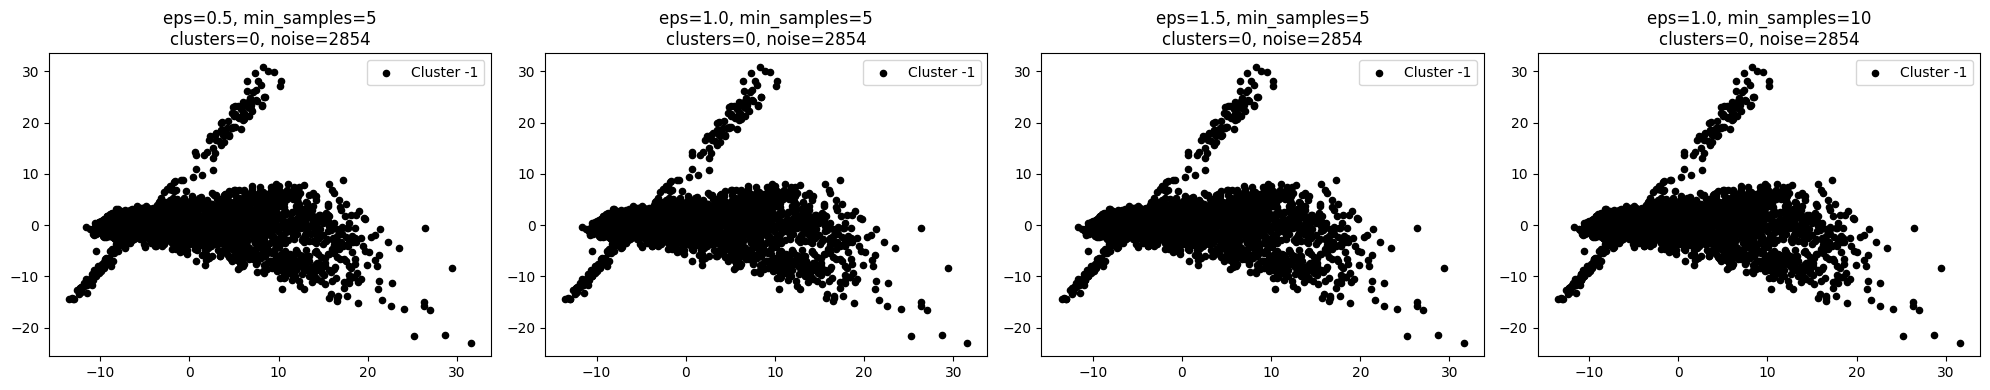

In [ ]:
# Define several parameter combinations to test
params = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 5},
    {'eps': 1.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 10},
]

# Store results for each configuration
results = []

for p in params:
    # Create and fit DBSCAN model
    db = DBSCAN(eps=p['eps'], min_samples=p['min_samples'])
    labels = db.fit_predict(X_scaled)

    # Calculate clustering metrics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    sil = silhouette_score(X_scaled, labels) if n_clusters > 1 else np.nan
    dbi = davies_bouldin_score(X_scaled, labels) if n_clusters > 1 else np.nan

    results.append({
        'params': p,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': sil,
        'dbi': dbi,
        'labels': labels
    })

# Show summary table of results
pd.DataFrame([{
    'eps': r['params']['eps'],
    'min_samples': r['params']['min_samples'],
    'Clusters': r['n_clusters'],
    'Noise Points': r['n_noise'],
    'Silhouette': r['silhouette'],
    'Davies-Bouldin': r['dbi']
} for r in results])

# Plot each parameter configuration side by side
fig, axes = plt.subplots(1, len(results), figsize=(5*len(results),4))
for ax, res in zip(axes, results):
    labels = res['labels']
    unique_labels = set(labels)
    for k in unique_labels:
        xy = X_vis[labels == k]
        color = 'black' if k == -1 else None
        ax.scatter(xy[:,0], xy[:,1], label=f'Cluster {k}', s=20, c=color)
    ax.set_title(f"eps={res['params']['eps']}, min_samples={res['params']['min_samples']}\n"
                 f"clusters={res['n_clusters']}, noise={res['n_noise']}")
    ax.legend()
plt.tight_layout()
plt.show()



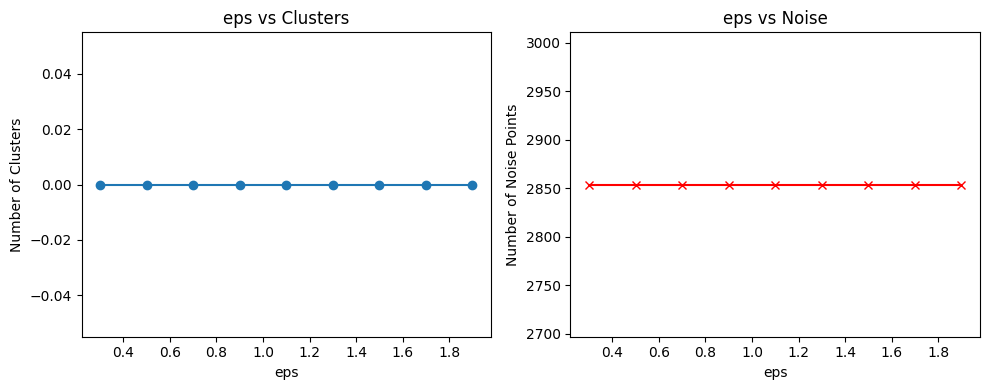

In [ ]:
# Vary eps from 0.3 to 2.0 and observe changes in cluster count and noise
eps_values = np.arange(0.3, 2.1, 0.2)
n_clusters_list, n_noise_list = [], []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)
    n_noise_list.append(list(labels).count(-1))

# Plot trends
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(eps_values, n_clusters_list, marker='o')
plt.xlabel('eps'); plt.ylabel('Number of Clusters')
plt.title('eps vs Clusters')

plt.subplot(1,2,2)
plt.plot(eps_values, n_noise_list, marker='x', color='red')
plt.xlabel('eps'); plt.ylabel('Number of Noise Points')
plt.title('eps vs Noise')
plt.tight_layout()
plt.show()


KMeans Silhouette Score: 0.22253734160396269


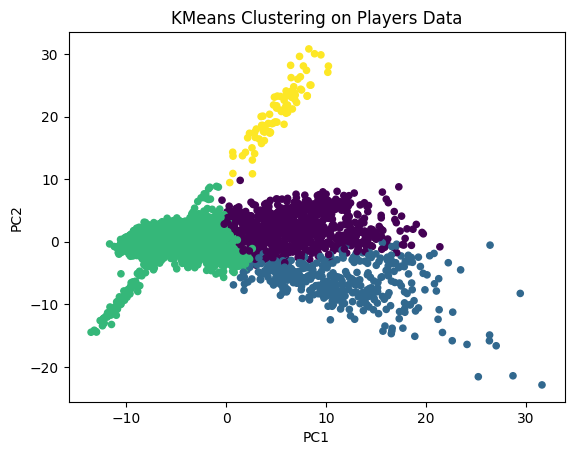

Clustered results saved as 'players_dbscan_results.csv'


In [ ]:
# Run KMeans for comparison (choose k = 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=0)
k_labels = kmeans.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, k_labels)
print("KMeans Silhouette Score:", sil_kmeans)

# Visualize KMeans result
plt.scatter(X_vis[:,0], X_vis[:,1], c=k_labels, cmap='viridis', s=20)
plt.title("KMeans Clustering on Players Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Apply DBSCAN with the chosen/best parameters (for example eps = 1.0)
best_dbscan = DBSCAN(eps=1.0, min_samples=5)
df['Cluster'] = best_dbscan.fit_predict(X_scaled)

# Export results to a new CSV file
df.to_csv("players_dbscan_results.csv", index=False)
print("Clustered results saved as 'players_dbscan_results.csv'")
